# **SENTIMENT ANALYSIS - UNSUPERVISED**

# Initialization

In [60]:
import json
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from sklearn.metrics import accuracy_score
from typing import Optional
import warnings
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
import itertools


In [61]:
# Load datasets    
with open('./data/original_data/X_test.json', 'r') as file:
    X_test = json.load(file)
    
with open('./data/original_data/y_test.json', 'r') as file:
    y_test = json.load(file)

with open('./data/original_data/X_val.json', 'r') as file:
    X_val = json.load(file)

with open('./data/original_data/y_val.json', 'r') as file:
    y_val = json.load(file)

In [62]:
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('universal_tagset')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [63]:
def fix_text(text:str) -> str:
    """
    Fix text by removing unwanted characters and adding spaces where needed.

    Parameters:
        text (str): Text to fix.

    Returns:
        str: Fixed text.
    """
    fixed_text = re.sub(r'[\\"\+\/]', '', text)
    fixed_text = re.sub(r'\s*([.,!\?;:])\s*', r'\1 ', fixed_text)
    fixed_text = re.sub(r'\s+\' s\s+', "'s ", fixed_text)
    fixed_text = re.sub(r'\s+\' t\s+', "'t ", fixed_text)
    fixed_text = re.sub(r'\s+\' re\s+', "'re ", fixed_text)
    fixed_text = re.sub(r'\s+\' ve\s+', "'ve ", fixed_text)
    fixed_text = re.sub(r'\s+\' ll\s+', "'ll ", fixed_text)
    fixed_text = re.sub(r'\s+', ' ', fixed_text)
    fixed_text = re.sub(r'\si\s', ' I ', fixed_text)
    fixed_text = re.sub(r'(?:^|(?<=[.!?]))\s*(\w)', lambda x: x.group(1).upper(), fixed_text)
    return fixed_text.strip()

def get_sentences(text:str, remove_stopwords:bool = False) -> list:
    """
    Get sentences from a text.

    Parameters:
        text (str): Text to analyze.
        remove_stopwords (bool): Whether to remove stopwords or not.
    
    Returns:
        list: List of sentences.
    """
    sent_list = nltk.sent_tokenize(text)
    if remove_stopwords:
        no_stopwords_sentences = []
        for sentence in sent_list:
            word_tokens = word_tokenize(sentence)
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
            filtered_sentence = []
            for w in word_tokens:
                if w not in stop_words:
                    filtered_sentence.append(w)
            no_stopwords_sentences.append(filtered_sentence)
        return no_stopwords_sentences
    else:
        return sent_list
    

def get_sentiment(synset:'Synset') -> Optional[tuple]:
    """
    Get sentiment scores for a synset.

    Parameters:
        synset (Synset): Synset to analyze.

    Returns:
        tuple: Tuple with positive, negative and objective scores if synset is found. None otherwise.
    """
    sentiment = swn.senti_synset(synset)
    return (sentiment.pos_score(), sentiment.neg_score(), sentiment.obj_score()) if sentiment else None

def score_synsets(synsets:list, score:str = 'obj', score_threshold:float = 0, merge_scores:str = 'mean', default:float = 0, hide_warnings:bool = False) -> float:
    """
    Compute a score for each synset in a list of synsets and merge them into a single score.

    Parameters:
        synsets (list): List of synsets.
        score (str): Score to compute. One of 'pos', 'neg', 'obj', 'max_score', 'dif', 'dif2', 'dif_threshold', 'dif2_threshold'.
        score_threshold (float): Threshold for 'dif_threshold' and 'dif2_threshold' scores. Scores below this threshold are set to 0.
        merge_scores (str): Method for merging scores into a single score. One of 'sum', 'mean', 'max', 'min', 'scale_norm1_mean', 'scale_norm2_mean'.
        default (float): Default score to return if synsets is empty.
        hide_warnings (bool): Whether to hide warnings or not.
        
    Returns:
        float: Merged score.
    """
    if len(synsets) == 0:
        if not hide_warnings:
            warnings.warn(f"Empty synsets list. Returning default score ({default}).", SyntaxWarning)
        return default

    if score == 'max_score' and merge_scores not in ['sum', 'mean']:
        if not hide_warnings:
            warnings.warn(f"Score 'max_score' is not compatible with '{merge_scores}'. Using 'sum' instead.", SyntaxWarning)
        merge_scores = 'sum'

    dict_score = {
        'pos': lambda s: s[0],
        'neg': lambda s: s[1], 
        'obj': lambda s: s[2],
        'max_score': lambda s: (-1 if s[0] > s[1] else 1) if s[0] != s[1] else 0,
        'dif': lambda s: s[0] - s[1],
        'dif2': lambda s: s[0]**2 - s[1]**2,
        'dif_threshold': lambda s: (s[0] if abs(s[0]) >= score_threshold else 0) - (s[1] if abs(s[1]) >= score_threshold else 0),
        'dif2_threshold': lambda s: (s[0]**2 if abs(s[0]) >= score_threshold else 0) - (s[1]**2 if abs(s[1]) >= score_threshold else 0),
        }
    
    assert score in dict_score.keys(), f"Score '{score}' not valid. Choose one of {list(dict_score.keys())}"
    
    def min_max_scale(scores:list[float|int]) -> list[float]:
        """
        Compute min-max scaling of a list of scores.

        Parameters:
            scores (list): List of scores.

        Returns:
            list: Scaled scores.
        """
        min_score = min(scores)
        max_score = max(scores)
        return [(s - min_score) / (max_score - min_score) for s in scores]

    dict_merge = {
        'sum': lambda sc: sum(sc),
        'mean': lambda sc: np.mean(sc),
        'max': lambda sc: max(sc),
        'min': lambda sc: min(sc),
        'scale_norm1_mean': lambda sc: np.mean(np.abs(min_max_scale(sc))),
        'scale_norm2_mean': lambda sc: np.linalg.norm(min_max_scale(sc)) / len(sc),
    }
    
    assert merge_scores in dict_merge.keys(), f"Merge score '{merge_scores}' not valid. Choose one of {list(dict_merge.keys())}"

    score_func = dict_score[score]
    scores = [score_func(get_sentiment(synset=s)) for s in synsets if s is not None]

    if merge_scores in ['scale_norm1_mean', 'scale_norm2_mean'] and min(scores) == max(scores):
        if not hide_warnings:
            warnings.warn(f"Scores are all the same and cannot be scaled. Returning default score ({default}).", RuntimeWarning)
        return default


    merge_func = dict_merge[merge_scores]
    scores_merged = merge_func(scores)

    return scores_merged

def discretize_scores(scores:list, threshold:float, positive_value = 1, negative_value = 0) -> list:
    """
    Returns a list of binary values based on a threshold.

    Parameters:
        scores (list): List of scores.
        threshold (float): Minimum value to consider a score as positive.
        positive_value: Value to assign to positive scores.
        negative_value: Value to assign to negative scores.
    """
    return list(map(lambda x: positive_value if x >= threshold else negative_value, scores))

def negativize(sentence):
    """
    Negativize a sentence by replacing words with their antonyms.

    Parameters:
        sentence (list): List of words.

    Returns:
        list: Negativized sentence.

    
    Based on https://gist.github.com/UtkarshRedd/3fbfd354ea7a6f83bd8f9419a27b0543
    """
    for i in range(2, len(sentence)):
        for distance in [1,2]:
            if sentence[i-distance] in ['not', "n't", "t", "DELETED"]:
                antonyms = []
                for syn in wn.synsets(sentence[i]):
                    for l in syn.lemmas():
                        if l.antonyms():
                            antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                antonym_max = None
                for ant in antonyms:
                    for syn in wn.synsets(ant):
                        w1 = wn.synsets(sentence[i])[0].name()
                        w2 = syn.name()
                        word1 = wn.synset(w1)
                        word2 = wn.synset(w2)
                        if isinstance(word1.path_similarity(word2), (float, int)):
                            temp = 1 - word1.path_similarity(word2)
                            if temp > max_dissimilarity:
                                max_dissimilarity = temp
                                antonym_max = ant
                if antonym_max:
                    sentence[i] = antonym_max
                    sentence[i-distance] = 'DELETED'
    sentence = [word for word in sentence if word != 'DELETED']
    return sentence

# LESK

In [9]:
def get_lesk_synsets(text:str, lemmatize:bool = False, remove_stopwords:bool = False, negatives:bool = False):
    tokens = word_tokenize(text)
    tagged_tokens = []
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    if remove_stopwords:
        tokens = [w for w in tokens if not w.lower() in stop_words]
    if negatives:
        tokens = negativize(tokens)
    if lemmatize or remove_stopwords or negatives:
        tagged_tokens = [a for a in nltk.pos_tag(tokens, tagset="universal")]
    else:
        tagged_tokens = [(a.text, a.pos_) for a in nlp(text)]
    words = []
    for token, pos in tagged_tokens:
        if pos == "NOUN":
            syn = lesk(tokens, token, pos="n")
        elif pos == "ADJ":
            syn = lesk(tokens, token) # pos "a" if not want s
        elif pos == "ADV":
            syn = lesk(tokens, token, pos="r")
        elif pos == "VERB":
            syn = lesk(tokens, token, pos="v")
        else:
            syn = None
        if syn is not None:
            words.append(syn)
    return words

def get_lesk_all_synsets(sentences:list, lemmatizer:bool = True) -> list:
    all = []
    for sentence in sentences:
        all.append(get_lesk_synsets(sentence, lemmatizer))
    return all

In [ ]:
test_synsets = []
for opinion in X_test:
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_lesk_all_synsets(s, lemmatizer=False)
    names = [[syn.name() for syn in ll] for ll in syns]
    test_synsets.append(names)

In [ ]:
with open('./data/lesk_test_synsets.json', 'w') as file:
    json.dump(test_synsets, file)

In [ ]:
val_synsets = []
for opinion in X_val:
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_lesk_all_synsets(s, lemmatizer=False)
    names = [[syn.name() for syn in ll] for ll in syns]
    val_synsets.append(names)

In [ ]:
with open('./data/synsets/lesk_val__negative_synsets.json', 'w') as file:
	json.dump(val_synsets, file)

# UKB

Own implementation of UKB since TextServer didn't allow us.

In [ ]:
from ukb import *
nlp = spacy.load("en_core_web_sm")
try:
    ukb_graph = load_ukb_graph("ukb_graph.gexf")
except:
    print("Creating graph...")
    ukb_graph = build_ukb_graph()
    nx.write_gexf(ukb_graph, "ukb_graph.gexf")

ukb = UKB(ukb_graph)
def get_ukb_synsets(text:str):
    context_words = extract_context_words(text)
    disambiguated_senses = ukb.disambiguate_context(context_words, method=2)
    return list(disambiguated_senses.values())

def get_ukb_all_synsets(sentences:list) -> list:
    all = []
    for sentence in sentences:
        all.append([a for a in get_ukb_synsets(sentence) if a != None])
    return all

In [ ]:
context_words = extract_context_words("find the solution to this problem")
disambiguated_senses = ukb.disambiguate_context(context_words, method=3)
print(disambiguated_senses)

In [ ]:
test_synsets = []
for i, opinion in enumerate(X_test):
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_ukb_all_synsets(s)
    test_synsets.append(syns)
    print(i, end="\r")

In [ ]:
with open('./data/ukb2_test_synsets.json', 'w') as file:
    json.dump(test_synsets, file)

In [ ]:
val_synsets = []
for i, opinion in enumerate(X_val):
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_ukb_all_synsets(s)
    val_synsets.append(syns)
    print(i, end="\r")

In [ ]:
with open('./data/synsets/ukb2_val_synsets.json', 'w') as file:
	json.dump(val_synsets, file)

# Frequencies

Using just the most freqüent synset

In [ ]:
frequencies = json.load(open("./data/synsets/word_sense_frequencies_semcor.json"))

def get_freq_synsets(text:str):
    tokens = word_tokenize(text)
    tagged_tokens = [(a.text, a.pos_) for a in nlp(text)]
    words = []
    for token, pos in tagged_tokens:
        if token not in frequencies.keys():
            syn = None
        else:
            if pos == "NOUN":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            elif pos == "ADJ":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            elif pos == "ADV":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            elif pos == "VERB":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            else:
                syn = None
        if syn is not None:
            words.append(syn.name() if syn.__class__.__name__ == "Lemma" else syn)
    return words

def get_freq_all_synsets(sentences:list) -> list:
    all = []
    for sentence in sentences:
        all.append([a for a in get_freq_synsets(sentence) if a != None])
    return all



In [ ]:
test_synsets = []
for i, opinion in enumerate(X_test):
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_freq_all_synsets(s)
    test_synsets.append(syns)
    print(i, end="\r")

In [ ]:
with open('./data/synsets/freq_test_synsets.json', 'w') as file:
    json.dump(test_synsets, file)

In [ ]:
with open('./data/synsets/ukb1_test_synsets.json', 'r') as file:
	test_synsets = json.load(file)

In [ ]:
allowed = [  "v", "a", "s", "n"]

In [ ]:
new_test_synsets = []

for opinion in test_synsets:
    new_opinion = []
    for sentence in opinion:
        filter_sentence = [name for name in sentence if name != "NE" and name.split('.')[1] in allowed]
        new_filter_sentence = []
        for a in filter_sentence:
            if "Lemma('" in a :
                n = a.replace("Lemma('", "").replace("')", "")
                n = n.split(".")
                n.pop(-1)
                n = ".".join(n)
            else:
                n = a
            try:
                get_sentiment(n)
                new_filter_sentence.append(n)
            except:
                print(n)
                pass
            
        filter_sentence = new_filter_sentence
        new_opinion.append(filter_sentence)
    new_test_synsets.append(new_opinion)

In [ ]:
with open('./data/synsets/freq_test_synsets.json', 'w') as file:
    json.dump(new_test_synsets, file)

# Validation and Testing

In [64]:
with open('./data/synsets/lesk_test_s_synsets.json', 'r') as file:
    test_synsets = json.load(file)

with open('./data/synsets/lesk_val_s_synsets.json', 'r') as file:
    val_synsets = json.load(file)

In [72]:
def validation(val_synsets:list, 
                          y_val:list, 
                          allowed:list = ["n", "a", "s", "v", "r"],
                          scores:list = ['pos', 'neg', 'obj', 'max_score', 'dif', 'dif2', 'dif_threshold', 'dif2_threshold'],
                          scores_thresholds:list = [0.05, 0.125, 0.25, 0.4, 0.6],
                          merges:list = ['sum', 'mean', 'max', 'min', 'scale_norm1_mean', 'scale_norm2_mean'],
                          thresholds = [-0.6, -0.4, -0.25, -0.125, -0.05, 0, 0.05, 0.125, 0.25, 0.4, 0.6]
                          ) -> tuple[list[tuple[tuple, tuple]], float, dict]:
    """
    Run a validation experiment with different parameters to find the best combination.

    Parameters:
        val_synsets (list): List of validation synsets.
        y_val (list): List of validation labels.
        allowed (list): Allowed POS tags.
        scores (list): List of scores to compute.
        scores_thresholds (list): List of thresholds for 'dif_threshold' and 'dif2_threshold' scores.
        merges (list): List of methods to merge scores.
        thresholds (list): List of thresholds for discretization.
    
    Returns:
        tuple: Best parameters (list of all combinations with the best accuracy), best accuracy (float) and results (dict of all combinations with their accuracy).
    """
    allow_combinations = list(itertools.chain.from_iterable(itertools.combinations(allowed, r) for r in range(1, len(allowed)+1)))
    results_allow = {tuple(a): dict() for a in allow_combinations} # Dict of allowed combinations. Each allowed combination has a dict of results
    iter = 1
    total_iters = len(scores) * len(merges) * len(thresholds) * len(allow_combinations)
    for score in scores:
        for merge in merges:
            for thresh in thresholds:
                for allow in results_allow.keys():
                    print(f"Running validation: {(iter/total_iters)*100:.2f}%", end="\r")
                    iter += 1

                    if score == 'max_score' and merge not in ['sum', 'mean']:
                        results_allow[tuple(allow)][(score, None, merge, thresh)] = float('nan')
                        continue

                    elif score in ['dif_threshold', 'dif2_threshold']:
                        for score_thresh in scores_thresholds:
                            acc, _ = run_experiment(synsets=val_synsets, y=y_val, allowed=list(allow), score=score, score_thresh=score_thresh, merge=merge, thresh=thresh, hide_warnings=True)
                            results_allow[allow][(score, score_thresh, merge, thresh)] = acc
                    else:
                        acc, _ = run_experiment(synsets=val_synsets, y=y_val, allowed=list(allow), score=score, merge=merge, thresh=thresh, hide_warnings=True)
                        results_allow[allow][(score, None, merge, thresh)] = acc

    best_acc = max([max(results_allow[allow].values()) for allow in results_allow.keys()])
    best_params = [(allow, params) for allow in results_allow.keys() for params, acc in results_allow[allow].items() if acc == best_acc]

    return best_params, best_acc, results_allow


def run_experiment(synsets:list, y:list, allowed:list, score:str, merge:str, thresh:float, score_thresh:float = 0, hide_warnings:bool = False, continuous:bool = False) -> tuple[float, list]:
    """
    Run an experiment with a set of parameters.

    Parameters:
        synsets (list): List of synsets.
        y (list): List of labels.
        allowed (list): Allowed POS tags.
        score (str): Score to compute.
        merge (str): Method to merge scores.
        thresh (float): Threshold for discretization.
        score_thresh (float): Threshold for 'dif_threshold' and 'dif2_threshold' scores.
        hide_warnings (bool): Whether to hide warnings or not.
        continuous (bool): Wheter to return continuous scores or not.

    Returns:
        tuple: Accuracy (float) and results (list of predictions).
    """
    scores_opinions = []
    for opinion in synsets:
        scores_sentences = []
        for sentence in opinion:
            filter_sentence = [name for name in sentence if name.split('.')[1] in allowed]
            scores_sentences.append(score_synsets(synsets=filter_sentence, score=score, merge_scores=merge, score_threshold=score_thresh, hide_warnings=hide_warnings))

        scores_opinions.append(np.mean(scores_sentences))

    if not continuous:
        results_opinions = discretize_scores(scores=scores_opinions, threshold=thresh)

        accuracy = accuracy_score(y, results_opinions)
    else:
        results_opinions = scores_opinions
        accuracy = 0.0

    return accuracy, results_opinions

In [8]:
best_params_val, best_acc_val, results_val = validation(val_synsets=val_synsets, y_val=y_val)

In [9]:
print(f"Best parameters for validation (Accuracy: {best_acc_val:.4f}):")
for allow, params in best_params_val:
	print(f"\t*ALLOWED POS TAGS: {allow}; PARAMETERS: Score: {params[0]}, Score threshold: {params[1]}, Merge: {params[2]}, Threshold: {params[3]}")

Best parameters for validation (Accuracy: 0.6560):
	*ALLOWED POS TAGS: ('n', 'a', 's', 'r'); PARAMETERS: Score: dif, Score threshold: None, Merge: sum, Threshold: 0
	*ALLOWED POS TAGS: ('n', 'a', 's', 'r'); PARAMETERS: Score: dif_threshold, Score threshold: 0.05, Merge: sum, Threshold: 0
	*ALLOWED POS TAGS: ('n', 'a', 's', 'r'); PARAMETERS: Score: dif_threshold, Score threshold: 0.125, Merge: sum, Threshold: 0


In [45]:
# Functions to save and load dictionaries with tuple keys
def dict_key_tuple_to_string(d: dict) -> dict:
	"""
	Convert a dictionary with depth 2 with tuple keys to a dictionary with string keys.

	Parameters:
		d (dict): Dictionary to convert.

	Returns:
		dict: Converted dictionary.
	"""
	return {" ".join([str(e1) for e1 in tk1]): {" ".join([str(e2) for e2 in tk2]): v2 for tk2, v2 in v1.items()} for tk1, v1 in d.items()}

def dict_key_string_to_tuple(d: dict) -> dict:
	"""
	Convert a dictionary with depth 2 with string keys to a dictionary with tuple keys.

	Parameters:
		d (dict): Dictionary to convert.

	Returns:
		dict: Converted dictionary.
	"""
	return {tuple(tk1.split(" ")): {tuple(tk2.split(" ")): v2 for tk2, v2 in v1.items()} for tk1, v1 in d.items()}

In [46]:
# Save results and best parameters of validation
with open('./data/results/unsupervised_results_val.json', 'w') as file:
	json.dump(dict_key_tuple_to_string(results_val), file)

with open('./data/results/unsupervised_best_params_val.json', 'w') as file:
	json.dump(best_params_val, file)

Best allowed POS tags for validation: ('n', 'a', 's', 'r')


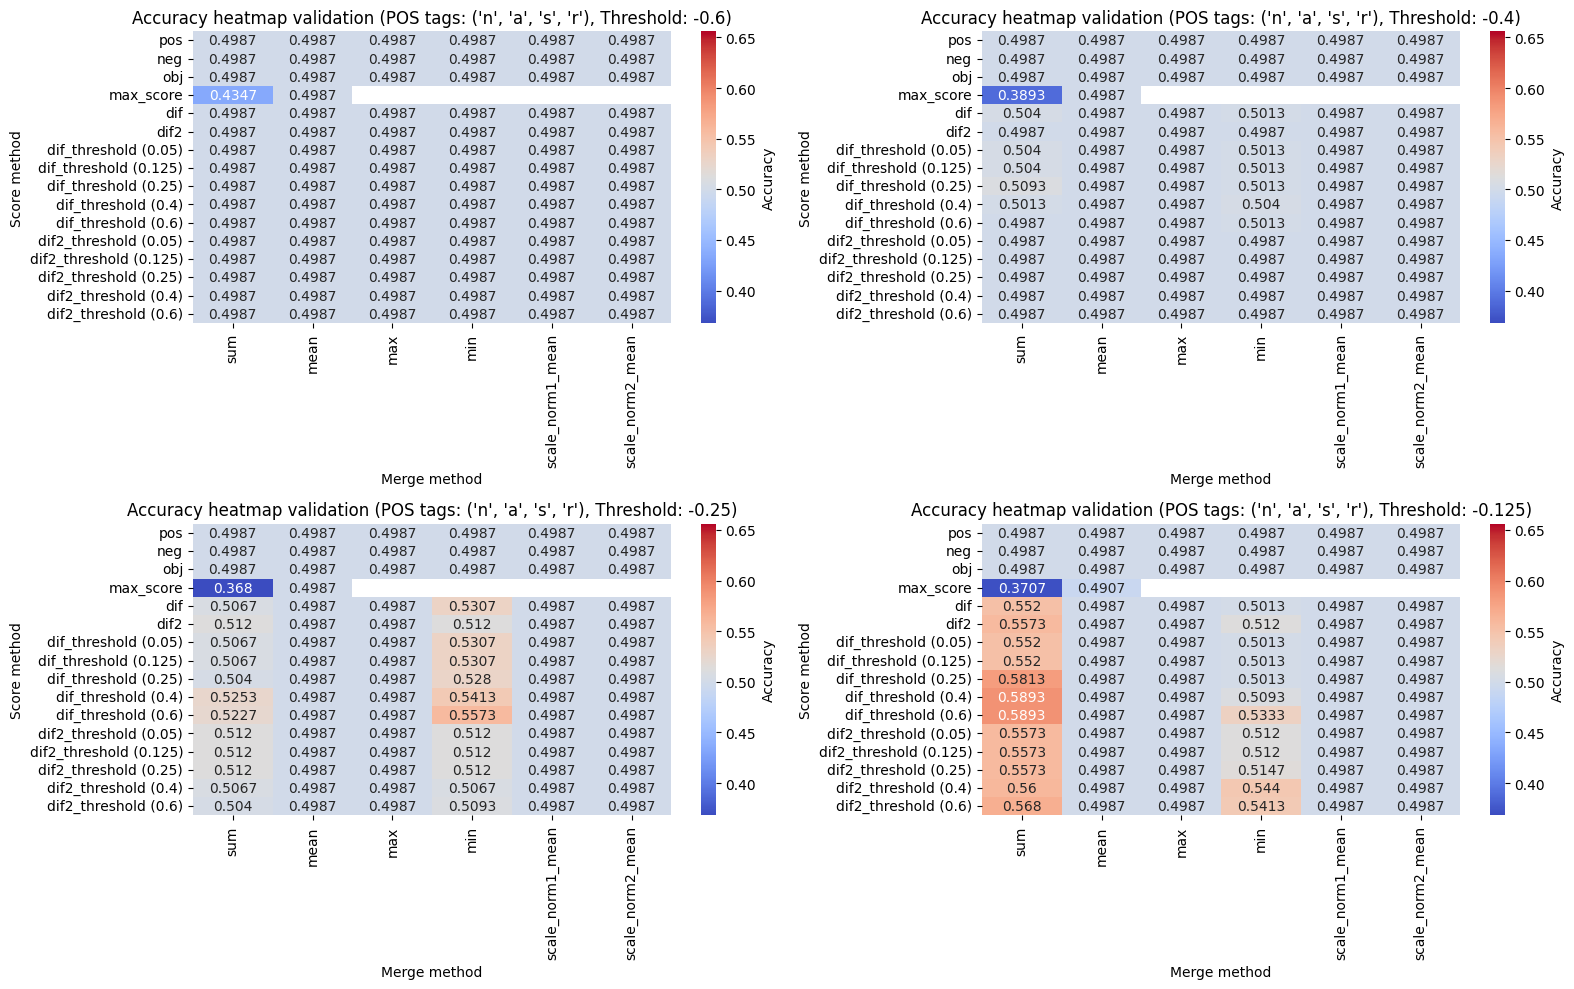

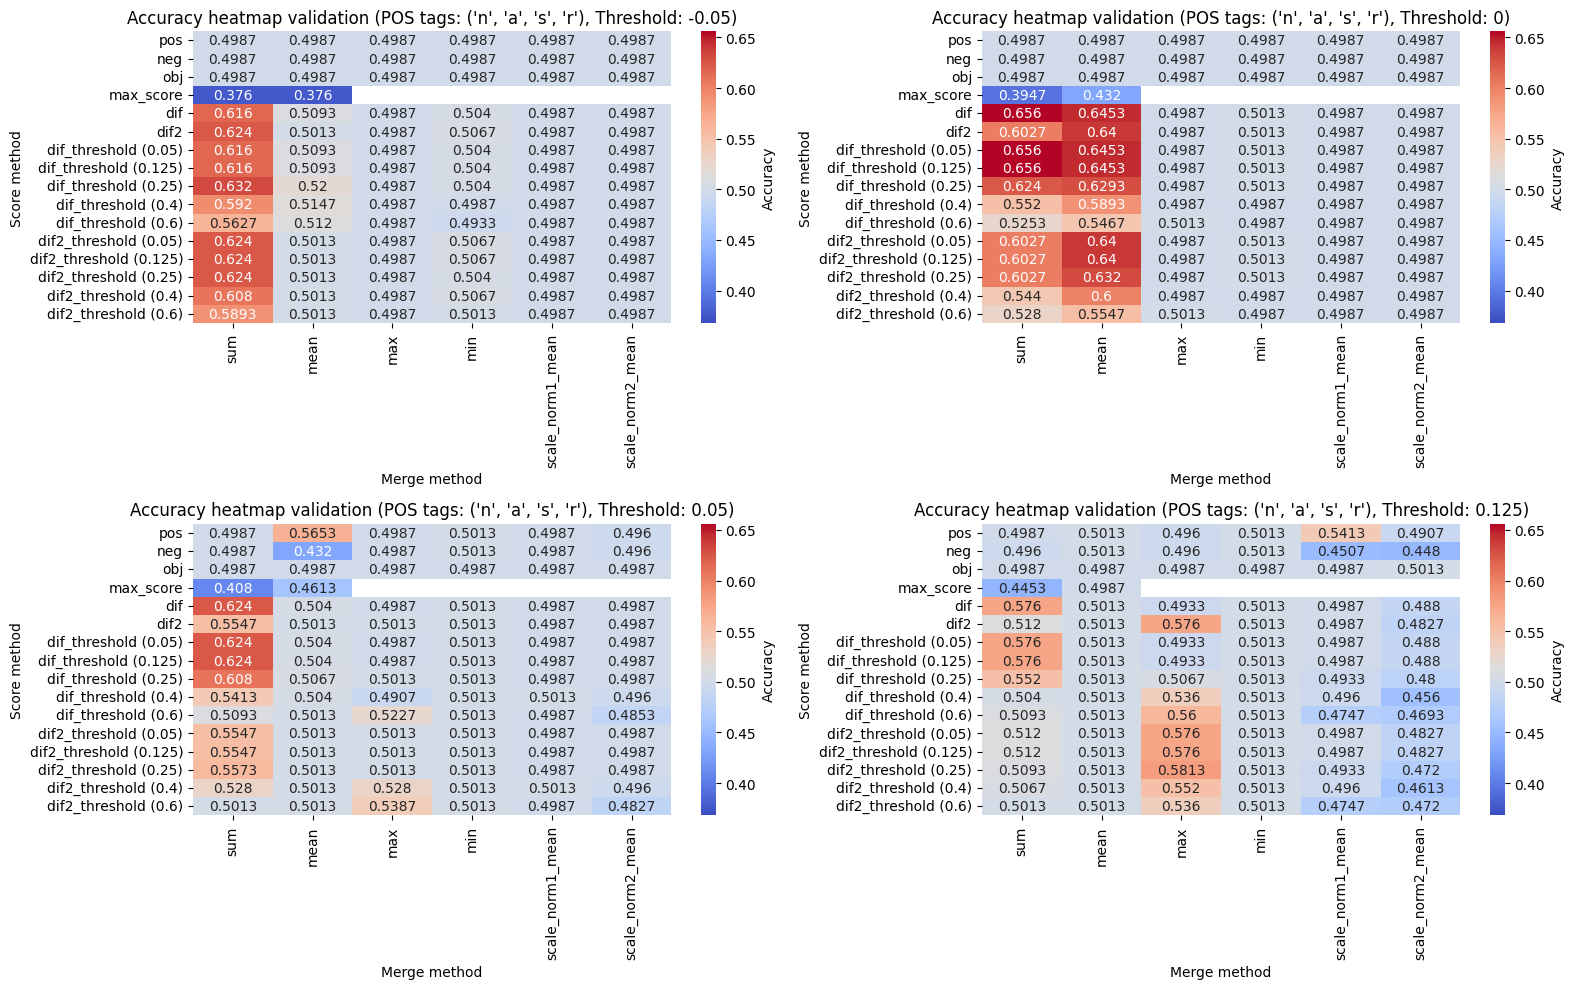

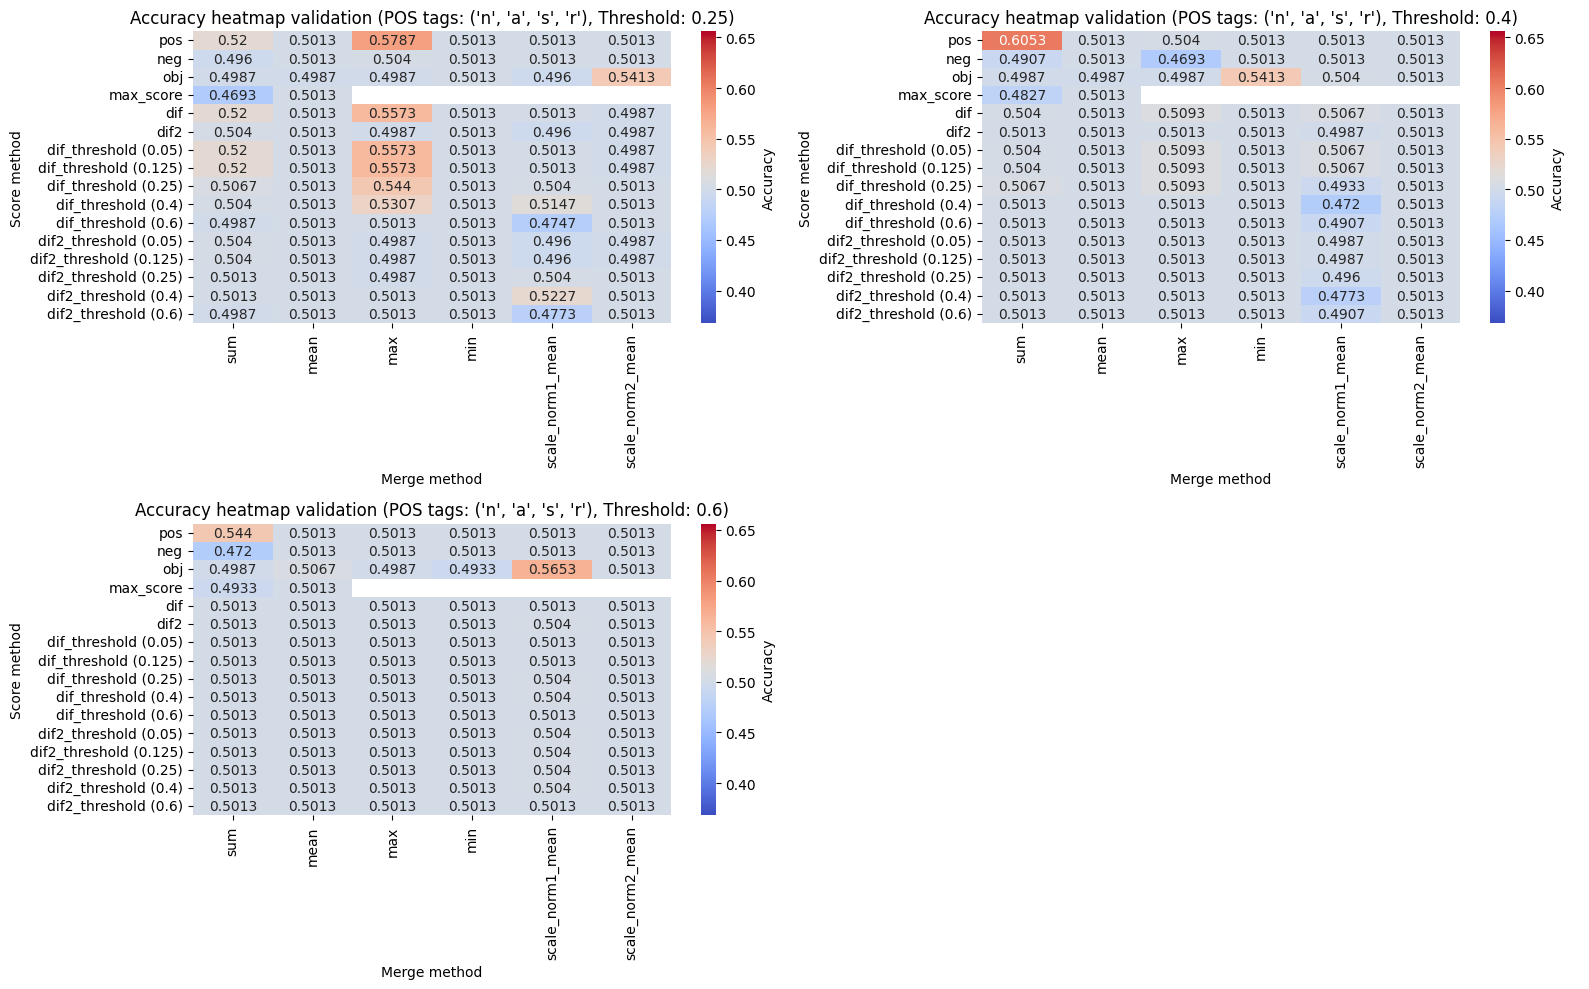

In [99]:
# Heatmap of validation results

# If there is only one combination of allowed POS tags with the best maximum accuracy, we choose that one
if np.all([best_params_val[0][0] == x[0] for x in best_params_val]):
    best_allow_comb_val = best_params_val[0][0]
# If there are multiple combinations of allowed POS tags with the best maximum accuracy, 
# we choose the one with the best average accuracy. 
# If there are still multiple combinations, we choose the one with the fewest allowed POS tags.
else:
	warnings.warn("Multiple combinations of allowed POS tags with the same maximum accuracy. Choosing the one with the best average accuracy, the fewest allowed POS tags or ultimately the first one.", RuntimeWarning)
	best_allow_comb_val = min(
		max(best_params_val, 
	  	key=lambda t: np.mean([acc for acc in results_val[t[0]].values()])), 
	key=lambda t: len(t[0]))
    
	if len(best_params_val) > 1:
		best_allow_comb_val = best_allow_comb_val[0]

print(f"Best allowed POS tags for validation: {best_allow_comb_val}")

results_best_allow_comb_val = results_val[best_allow_comb_val]
scores = [('pos', None), ('neg', None), ('obj', None), ('max_score', None), ('dif', None), ('dif2', None)]
scores_thresholds = [0.05, 0.125, 0.25, 0.4, 0.6]
scores = scores + [('dif_threshold', score_thresh) for score_thresh in scores_thresholds] + [('dif2_threshold', score_thresh) for score_thresh in scores_thresholds]
merges = ['sum', 'mean', 'max', 'min', 'scale_norm1_mean', 'scale_norm2_mean']
thresholds = [-0.6, -0.4, -0.25, -0.125, -0.05, 0, 0.05, 0.125, 0.25, 0.4, 0.6]
scores_ticks = [f"{score[0]} ({score[1]})" if score[1] is not None else score[0] for score in scores]

num_thresholds = len(thresholds)
ncols = 2
nrows = 2

all_results = []
for thresh in thresholds:
    results_matrix = np.zeros((len(scores), len(merges)))
    for i, score in enumerate(scores):
        for j, merge in enumerate(merges):
            results_matrix[i, j] = round(results_best_allow_comb_val[(score[0], score[1], merge, thresh)], 4)
    all_results.append(results_matrix)

min_val = min(np.nanmin(matrix) for matrix in all_results)
max_val = max(np.nanmax(matrix) for matrix in all_results)

idx_correction = 0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8, nrows*5))
if nrows == 1 and ncols == 1:
    axes = np.array([axes])  # Hacer axes iterable incluso si hay solo un subplot
else:
    axes = axes.flatten()

for thresh, results_matrix, idx in zip(thresholds, all_results, range(num_thresholds)):
    actual_idx = idx % (nrows * ncols)

    sns.heatmap(results_matrix, ax=axes[actual_idx], annot=True, xticklabels=merges, yticklabels=scores_ticks, fmt='g', cmap='coolwarm', cbar=True, cbar_kws={'label': 'Accuracy'}, vmin=min_val, vmax=max_val)
    axes[actual_idx].set_xlabel('Merge method')
    axes[actual_idx].set_ylabel('Score method')
    axes[actual_idx].set_title(f'Accuracy heatmap validation (POS tags: {best_allow_comb_val}, Threshold: {thresh})')

    # Show a new figure every nrows * ncols figures or in the last figure
    if (idx + 1) % (nrows * ncols) == 0 or (idx + 1) == num_thresholds:
        # Remove unused axes
        if (idx + 1) == num_thresholds:
            remaining_axes = (nrows * ncols) - (idx % (nrows * ncols) + 1)
            for unused_ax in axes[actual_idx + 1:actual_idx + 1 + remaining_axes]:
                unused_ax.axis('off')

        plt.tight_layout()
        plt.show()

        if idx + 1 < num_thresholds:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8, nrows*5))
            if nrows == 1 and ncols == 1:
                axes = np.array([axes])  # Hacer axes iterable incluso si hay solo un subplot
            else:
                axes = axes.flatten()


In [67]:
# Read the results of the validation
with open('./data/results/unsupervised_results_val.json', 'r') as file:
	results_val = dict_key_string_to_tuple(json.load(file))

# Read the best parameters of the validation
with open('./data/results/unsupervised_best_params_val.json', 'r') as file:
	best_params_val = [(tuple(e[0]), tuple(e[1])) for e in json.load(file)]

In [125]:
def plot_cm(y_true: list, y_pred: list):
	from sklearn.metrics import confusion_matrix

	cm = confusion_matrix(y_true, y_pred)

	fig, ax = plt.subplots(figsize=(6, 6))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax)
	ax.set_xlabel('Predicted')
	ax.set_ylabel('True')
	plt.title('Confusion matrix')
	plt.show()

In [121]:
# Confusion matrix of the best parameters on the validation set
_, y_pred = run_experiment(synsets=val_synsets, y=y_val, allowed=['n', 'a', 's', 'r'], score='dif', merge='sum', thresh=0)

plot_cm(y_true=y_val, y_pred=y_pred)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17016\2719992697.py:80: SyntaxWarning: Empty synsets list. Returning default score (0).
  warnings.warn(f"Empty synsets list. Returning default score ({default}).", SyntaxWarning)


NameError: name 'plot_cm' is not defined

In [74]:
# Executions of the best parameters on the test set
acc, y_pred = run_experiment(synsets=test_synsets, y=y_test, allowed=['n', 'a', 's', 'r'], score='dif', merge='sum', thresh=0.03, hide_warnings=True)
print(f"Accuracy on test set: {acc:.4f}")

Accuracy on test set: 0.0000
0.5277777777777778 -0.5175333333333333


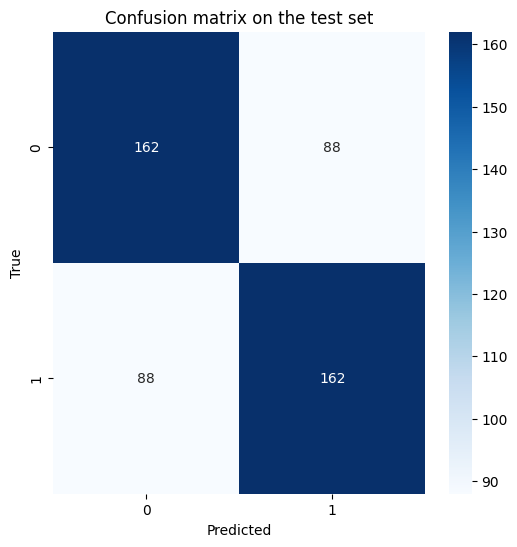

In [133]:
# Confusion matrix of the test set
plot_cm(y_true=y_test, y_pred=y_pred)

Accuracy on test set: 0.0000
0.5277777777777778 -0.5175333333333333


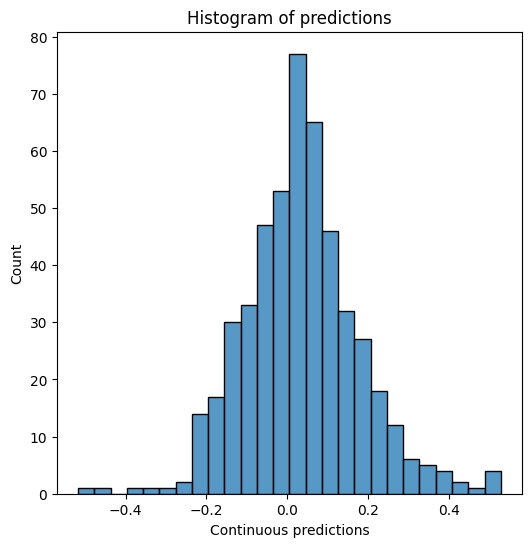

In [79]:
acc, y_pred = run_experiment(synsets=test_synsets, y=y_test, allowed=['n', 'a', 's', 'r'], score='dif', merge='sum', thresh=0.03, hide_warnings=True, continuous = True)
print(f"Accuracy on test set: {acc:.4f}")
print(max(y_pred), min(y_pred))

fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(y_pred)
ax.set_xlabel('Continuous predictions')
plt.title('Histogram of predictions')
plt.show()

La distribució té mitjana 0.034932448806907074 i desviació estàndard 0.14284295662128424
Original Values: [0.0625, -0.06818181818181818, 0.07222222222222222, -0.1111111111111111, 0.0325, 0.05082926829268293, -0.10887096774193548, 0.18548387096774194, 0.05078125, -0.07664]
Probabilities: [0.57651739 0.23518673 0.6029747  0.15329428 0.49320681 0.54430633
 0.15703374 0.85405044 0.54417304 0.21737634]


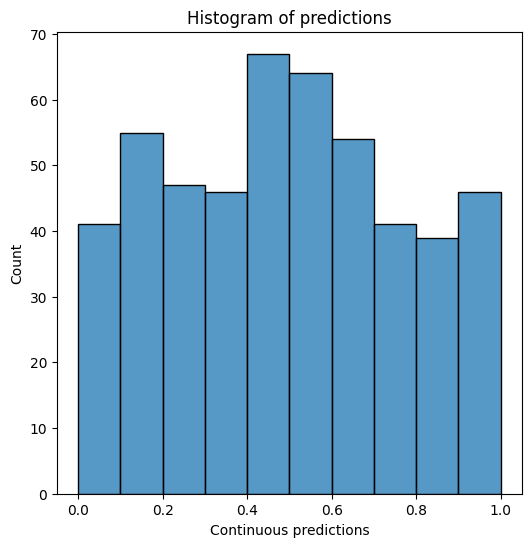

In [86]:
import numpy as np
from scipy.stats import norm

mean = np.mean(y_pred)
std_dev = np.std(y_pred)

print(f"La distribució té mitjana {mean} i desviació estàndard {std_dev}")

# Compute the probabilities using the CDF
probabilities = norm.cdf(y_pred, loc=mean, scale=std_dev)

print("Original Values:", y_pred[:10])
print("Probabilities:", probabilities[:10])

fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(probabilities)
ax.set_xlabel('Continuous predictions')
plt.title('Histogram of predictions')
plt.show()

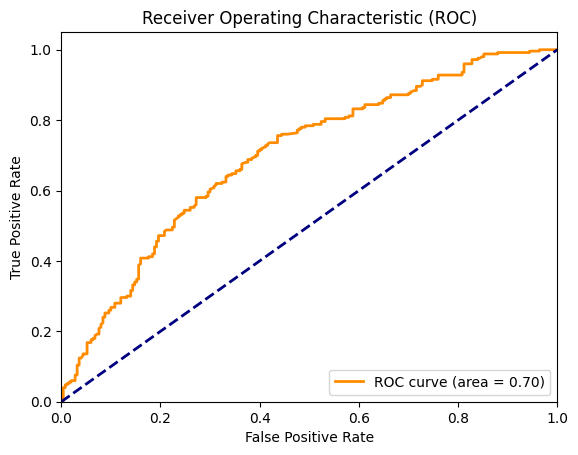

In [87]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [130]:
# Experiment with another synsets (UKB 3) and with only taking "extreme" values
with open('./data/synsets/ukb3_test_synsets50.json', 'r') as file:
    test_synsets = json.load(file)
    
allowed=['n', 'a', "r", 'v']
results = []
scores_obj = []
scores_res = []
for opinion in test_synsets:
    total_pos = 0
    total_neg = 0
    total_obj = 0
    for sentence in opinion:
        filter_sentence = [name for name in sentence if name.split('.')[1] in allowed]
        scores = [get_sentiment(syn) for syn in filter_sentence if get_sentiment(syn) != None]
        if len(scores) > 0:
            total_pos += sum(s[0] for s in scores if s[0] > 0.5) / len(scores)
            total_neg += sum(s[1] for s in scores if s[1] > 0.5) /len(scores)
            total_obj += sum(s[2] for s in scores) /len(scores)
    score = total_obj
    scores_obj.append(total_obj)
    scores_res.append(total_pos - total_neg)
results = [0 if a < 0  else 1 for a in scores_res]

print(accuracy_score(y_test[:50], results))

0.7


In [150]:
accuracy, pred = run_experiment(synsets=test_synsets, y=y_test[:50], allowed=['n', 'a',"r",  'v'], score='dif_threshold',score_thresh=0.6, merge='mean', thresh=-0, hide_warnings=True)
accuracy

0.7

In [ ]:
plot_cm(y_true=y_test[:50], y_pred=pred)

# Alternatives

There are other approaches that can be also useful.

In [102]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

scores_opinions = []
for opinion in X_test[:50]:
    scores_sentences = []
    for sentence in sent_tokenize(opinion):
        scores = analyzer.polarity_scores(sentence)
        resta = scores["pos"] - scores["neg"]
        scores_sentences.append(resta)
    scores_opinions.append(np.mean(scores_sentences))

results_opinions = discretize_scores(scores=scores_opinions, threshold=0.06)

accuracy_score(y_test[:50], results_opinions)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0.62

In [107]:
results_opinions = discretize_scores(scores=scores_opinions, threshold=0.6)
accuracy_score(y_test[:50], results_opinions)

0.52